In [ ]:
!pip install keras==2.15.0

In [ ]:
!pip install pandas==1.5.3

In [ ]:
!pip install gensim --upgrade

In [47]:
# Imports various modules and classes from scikit-learn for tasks like splitting datasets, encoding labels.
# Computing confusion matrices and classification reports, and extracting TF-IDF features.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
# imports various modules and classes from Keras, including components for text preprocessing,
# model building (sequential and functional APIs),layers (such as dense, convolutional, LSTM),
# utilities, and callbacks for training optimization like reducing learning rate and early stopping.
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [50]:
# imports utility modules and functions such as regular expression operations.
# numpy for numerical computations, operating system functions, counter for counting occurrences.
# logging for logging messages, time for time-related functions, pickle for object serialization.
# and itertools for iterating over combinations.
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [51]:
# sets up logging configuration to format log messages with timestamp.
# log level, and message content, and sets the logging level to INFO.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [52]:
# imports NLTK and snowballstemmer, to download stopwords and also for word stemming
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
# defines the column names and encoding the dataset
data_column = ["target", "ids", "date", "flag", "user", "text"]
data_encode = "ISO-8859-1"

In [54]:
# defining the filenames for exporting trained models and tokenizer/encoder objects, with the Keras model
keras = "model.h5"
W2V_model = "model.w2v"
token_model = "tokenizer.pkl"
encode_model = "encoder.pkl"

In [55]:
# importing the pandas library, reads the CSV file, assigning column name
import pandas as pd
datapath = "/content/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(datapath, encoding=data_encode, names=data_column)

In [56]:
# defining constants for the sentiment labels and decoding the sentiment labels of the input data
positive_sentiment = "POSITIVE"
negative_sentiment = "NEGATIVE"
neutral_sentiment = "NEUTRAL"
sentiment_threshold = (0.4, 0.7)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [57]:
# applying the decode sentiment function
df.target = df.target.apply(lambda x: decode_sentiment(x))

Dataset size: 1600000


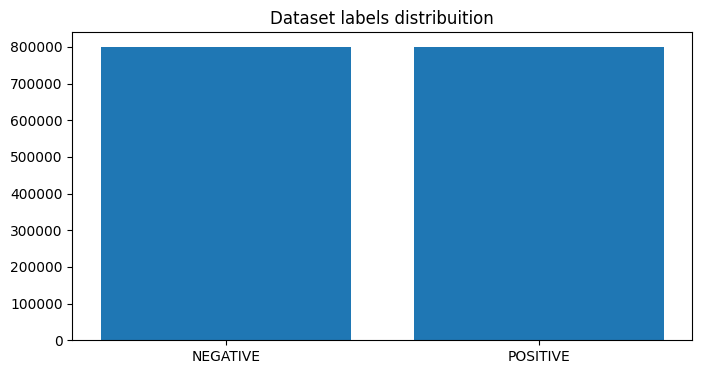

In [58]:
# imports Matplot library, plotting a bar graph for the visualisation of dataset labels distribution.
import matplotlib.pyplot as plt
TARGET_COUNT = Counter(df.target)

plt.figure(figsize=(8,4))
plt.bar(TARGET_COUNT.keys(), TARGET_COUNT.values())
plt.title("Dataset labels distribuition")
print("Dataset size:", len(df))

In [59]:
# importing the english stopwords and stemming from nltk library and snowballstemmer.
STOPWORDS = stopwords.words("english")
STEMMING = SnowballStemmer("english")

In [60]:
#  preprocesses text by removing links, usernames, and special characters,
#  tokenizing the text, removing stopwords, and optionally applying stemming.
def preprocess(text, stem=False):
    text_clean = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_clean, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in STOPWORDS:
            if stem:
                tokens.append(STEMMING.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [61]:
# cleanses and preprocesses the data
df.text = df.text.apply(lambda x: preprocess(x))

In [62]:
# splitting the dataframe into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)
print("TRAIN size:", len(train))
print("TEST size:", len(test))

TRAIN size: 1280000
TEST size: 320000


In [63]:
# documenting the tokenized words
documents = [_text.split() for _text in train.text]

In [64]:
# initializing the word2vec model
import gensim
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=300, window=7, min_count=10, workers=8)


In [65]:
# builds word2vec model using the tokenized documents
w2v_model.build_vocab(documents)

In [66]:
# retrives the words and calculates vocabulary size
words = list(w2v_model.wv.key_to_index.keys())
Vocab_size = len(words)

In [67]:
# Building the vocabulary
w2v_model.build_vocab(documents)

# Training the Word2Vec model
w2v_model.train(documents, total_examples=len(documents), epochs=32)


(263122338, 295270528)

In [68]:
# initializes the tokenizer, fits text data in the training dataset, calculates vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)

Vocab_size = len(tokenizer.word_index) + 1

In [69]:
# converts the text data in the training and testing datasets
x_train = pad_sequences(tokenizer.texts_to_sequences(train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text), maxlen=300)

In [70]:
# creates a list of unique target labels
labels = train.target.unique().tolist()
labels.append(neutral_sentiment)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [71]:
# encodeing the training and testing labels
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [74]:
# initializes a embedding matrix, then iterates through each word
embedding_matrix = np.zeros((Vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

In [75]:
# defining a embedding layer, initializing the weights
embedding_layer = Embedding(Vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [76]:
# defining sequential model and adds embedding layer, dropout, lstm and dense layers
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          87125700  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


In [77]:
# compiles specifying binary cross entrophy as loss function, adam optimzer and accuracy as evaluation metrics
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [78]:
# defining call back function for early stoping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]


In [79]:
# training of the model
history = model.fit(x_train, y_train, batch_size=1024, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/20
1125/1125 [==============================] - 444s 393ms/step - loss: 0.5028 - accuracy: 0.7507 - val_loss: 0.4665 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/20
1125/1125 [==============================] - 440s 391ms/step - loss: 0.4786 - accuracy: 0.7671 - val_loss: 0.4592 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 3/20
1125/1125 [==============================] - 437s 389ms/step - loss: 0.4717 - accuracy: 0.7720 - val_loss: 0.4538 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 4/20
1125/1125 [==============================] - 437s 389ms/step - loss: 0.4676 - accuracy: 0.7750 - val_loss: 0.4530 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 5/20
1125/1125 [==============================] - 441s 392ms/step - loss: 0.4653 - accuracy: 0.7761 - val_loss: 0.4497 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 6/20
1125/1125 [==============================] - 443s 394ms/step - loss: 0.4635 - accuracy: 0.7773 - val_loss: 0.4488 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 7/20
1125/1125 [============

In [80]:
# evaluaTION OF the trained model using test data
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("Accuracy:",score[1])
print("Loss:",score[0])

313/313 [==============================] - 33s 105ms/step - loss: 0.4436 - accuracy: 0.7930

Accuracy: 0.7930031418800354
Loss: 0.4436311423778534


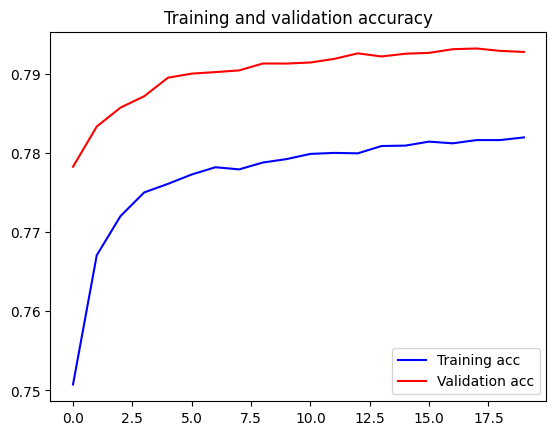

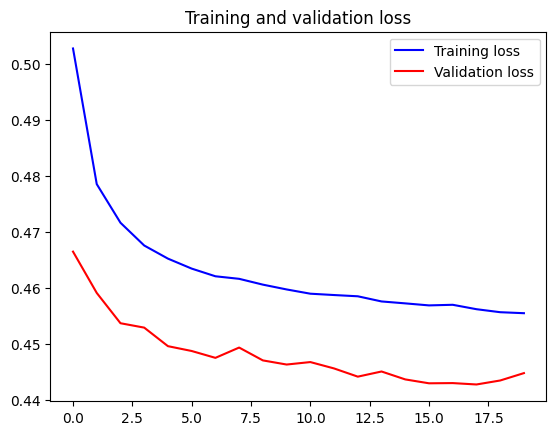

In [81]:
# visualisation of training and validation accuracy and training and validation loss
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']


epochs = range(len(accuracy))

plt.plot(Epochs, accuracy, 'b', label='Training acc')
plt.plot(Epochs, validation_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(Epochs, loss, 'b', label='Training loss')
plt.plot(Epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
# mapping of sentiment scores to sentiment labels using decode sentiment function
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = neutral_sentiment
        if score <= sentiment_threshold[0]:
            label = negative_sentiment
        elif score >= sentiment_threshold[1]:
            label = positive_sentiment

        return label
    else:
        return negative_sentiment if score < 0.5 else positive_sentiment

In [83]:
# Predict function to predict the sentiment label
def predict(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    score = model.predict([x_test])[0][0]  # to extract a single element
    # Mapping the score to the range of 0 to 10
    mapped_score = int(score * 10)
    # Decoding the sentiment
    if mapped_score <= 3:
        label = "HIGHLY NEGATIVE"
        polarity = "Highly Negative"
    elif mapped_score <= 5:
        label = "NEGATIVE"
        polarity = "Negative"
    elif mapped_score == 6:
        label = "NEUTRAL"
        polarity = "Neutral"
    elif mapped_score <= 8:
        label = "POSITIVE"
        polarity = "Positive"
    else:
        label = "HIGHLY POSITIVE"
        polarity = "Highly Positive"

    return {"label": label, "score": mapped_score, "polarity": polarity}

# inputing the text from user for prediction of the desired text
user_input = input("Enter your text: ")
prediction = predict(user_input)
print("Predicted Label:", prediction["label"])
print("Predicted Score:", prediction["score"])
print("Predicted Polarity:", prediction["polarity"])


Enter your text: i am happy
1/1 [==============================] - 0s 272ms/step
Predicted Label: POSITIVE
Predicted Score: 8
Predicted Polarity: Positive


In [84]:
# predicts for the testing data, decodes sentiment scores into sentiment labels
y_pred_1d = []
y_test_1d = list(test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 22s 551ms/step


In [85]:
# plotting a confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text( j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black" )

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

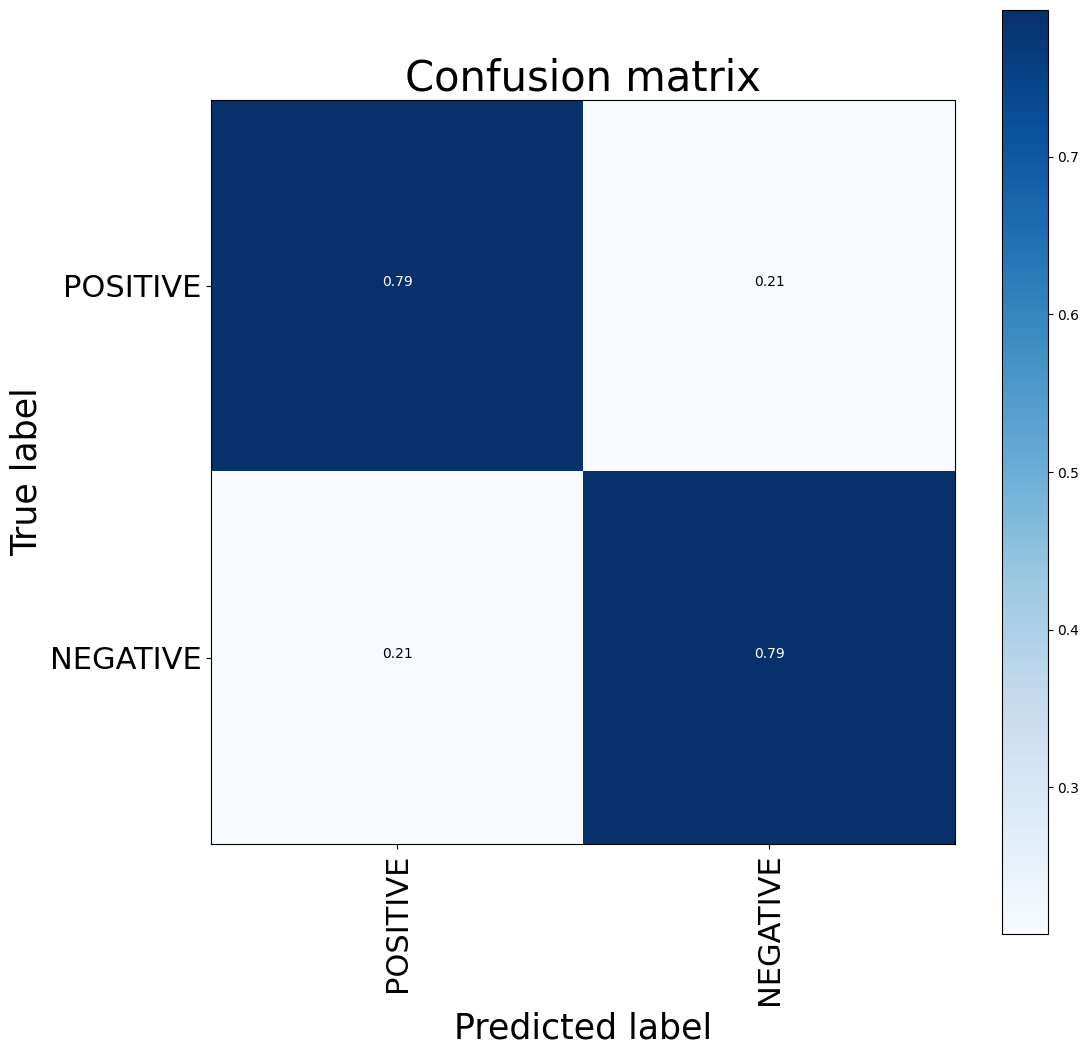

In [86]:
# computes confusion matrix using true klabels and predicted labels
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=train.target.unique(), title="Confusion matrix")
plt.show()

In [87]:
# calculating the accuracy by comparing thwe true labels and the predicted labels
accuracy_score(y_test_1d, y_pred_1d)

0.793003125

In [88]:
# computing the classification report
from sklearn.metrics import classification_report

y_true = test.target.tolist()
y_true = [str(label) for label in y_true]
y_pred = [decode_sentiment(score, include_neutral=False) for score in scores]

# Compute classification report
report = classification_report(y_true, y_pred, target_names=train.target.unique())

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.79      0.79      0.79    159494
    NEGATIVE       0.79      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [89]:
model.save(keras)
w2v_model.save(W2V_model)
pickle.dump(tokenizer, open(token_model, "wb"), protocol=0)
pickle.dump(encoder, open(encode_model, "wb"), protocol=0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
